In [2]:
!pip install opencv-python
!pip install tqdm
!pip install imgaug
!pip install imageio

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
from skimage.feature import hog
from skimage.io import imread
from skimage.transform import resize
import imgaug as ia
from imgaug import augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
import imageio.v2 as imageio
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report

In [4]:
print(cv2.__version__)

4.9.0


In [5]:
# Chargement des images depuis un dossier
image_folder = "./dataset/images/"
images = os.listdir(image_folder)
images = [os.path.join(image_folder, img) for img in images]
images[30]

'./dataset/images/acc1-6-_jpg.rf.0acbfc206f6e8d9021f00903414e7909.jpg'

In [6]:
# Chargement des labels depuis un dossier
labels_folder = "./dataset/labels/"
labels = os.listdir(labels_folder)
labels = [os.path.join(labels_folder, label) for label in labels]
labels[30]

'./dataset/labels/acc1-6-_jpg.rf.0acbfc206f6e8d9021f00903414e7909.txt'

In [7]:
len(images), len(labels)

(1258, 1268)

In [8]:
input_size=len(images)

In [9]:
image = imread(images[10])
image.shape

(640, 640, 3)

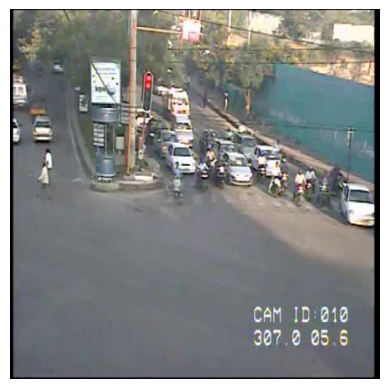

In [10]:
# Affichage de l'image
plt.imshow(image)
plt.axis('off')  # pour cacher les axes
plt.show()

In [25]:
import os

def parse_bounding_boxes(text_file_paths):
    """
    Parses bounding boxes from a list of text file paths.

    Parameters:
    - text_file_paths: A list of file paths to text files containing bounding box data.

    Returns:
    A list of dictionaries, each containing the file path as the key and a list of bounding boxes as the value.
    For images with multiple boxes, each box is a separate entry in the list.
    For images without boxes, returns a default box value list.
    """
    results = []

    for path in text_file_paths:
        # Extract the file name without the extension to use as the key
        file_name = os.path.splitext(os.path.basename(path))[0]
        image_path = f'./dataset/images/{file_name}.jpg'

        # Initialize an empty list to hold the bounding boxes for this image
        bounding_boxes = []

        # Check if the file exists and is not empty
        if os.path.exists(path) and os.path.getsize(path) > 0:
            with open(path, 'r') as file:
                # Read the bounding box data
                data = file.read().strip()
                # Split by lines to handle multiple bounding boxes per image
                lines = data.splitlines()
                for line in lines:
                    # Split by spaces to get individual coordinates, skipping the class label
                    box = list(map(float, line.split()[1:]))
                    bounding_boxes.append(box)
        else:
            # For files that are missing or empty, return a default box
            # Default box [0,0,1,1] assumes a box that covers the entire image
            bounding_boxes.append([0.0, 0.0, 1.0, 1.0])

        # Add the bounding boxes for this image to the results
        for box in bounding_boxes:
            results.append({image_path: box})

    return results

# Example usage:
bounding_boxes = parse_bounding_boxes(labels)
bounding_boxes

[{'./dataset/images/5_10_jpg.rf.5639f7a69885c595fc4b54e55dbf5148.jpg': [0.0,
   0.0,
   1.0,
   1.0]},
 {'./dataset/images/5_11_jpg.rf.99ee6f27d5d5f353e00506003993302a.jpg': [0.0,
   0.0,
   1.0,
   1.0]},
 {'./dataset/images/5_12_jpg.rf.f46713998d4579eabe3baf01d0bc605c.jpg': [0.0,
   0.0,
   1.0,
   1.0]},
 {'./dataset/images/5_13_jpg.rf.d4959906ae25dc3b28e2e43553764b1c.jpg': [0.0,
   0.0,
   1.0,
   1.0]},
 {'./dataset/images/5_14_jpg.rf.af89c1ce48edc27397830962d43d5c6a.jpg': [0.0,
   0.0,
   1.0,
   1.0]},
 {'./dataset/images/5_15_jpg.rf.02c45be3c76c4201f24dd386e060ed8c.jpg': [0.0,
   0.0,
   1.0,
   1.0]},
 {'./dataset/images/5_16_jpg.rf.ac71b8803fe5c99c3fc1e6867351c0bb.jpg': [0.0,
   0.0,
   1.0,
   1.0]},
 {'./dataset/images/5_17_jpg.rf.0611b10e50517e4323c47fc36301167c.jpg': [0.0,
   0.0,
   1.0,
   1.0]},
 {'./dataset/images/5_22_jpg.rf.368e2a41bf84be83076f603939cbd052.jpg': [0.0,
   0.0,
   1.0,
   1.0]},
 {'./dataset/images/5_23_jpg.rf.b98dce2a37d470d921751909d8030cee.jpg': [0

In [12]:
def get_targets(data):
    targets_array = []
    for key, value in data.items():
        if value == [()]:
            targets_array.append(0)
        else:
            targets_array.append(1)
    return np.array(targets_array)

targets = get_targets(bounding_boxes)
targets

array([0, 0, 0, ..., 0, 0, 0])

In [13]:
targets.shape

(1268,)

In [14]:
np.unique(targets, return_counts=True)

(array([0, 1]), array([557, 711], dtype=int64))

In [15]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import io

# Function to draw a single bounding box on image
def draw_box(image_data, box, color='green'):
    # Unpack the box values
    if box: 
        _, x_center, y_center, width, height = box
        # Convert to x, y from top left and width and height in pixels
        x = (x_center - (width / 2)) * image_data.size[0]
        y = (y_center - (height / 2)) * image_data.size[1]
        width_pixels = width * image_data.size[0]
        height_pixels = height * image_data.size[1]

        # Create the rectangle and add it to the plot
        rect = patches.Rectangle((x, y), width_pixels, height_pixels, linewidth=1, edgecolor=color, facecolor='none')
        return rect
    else:
        return None

# Function to visualize bounding boxes
def visualize_boxes(images, boxes):
    fig, axs = plt.subplots(len(images), 1, figsize=(5, len(images)))
    if len(images) == 1:
        axs = [axs]  # Make it iterable

    for ax, image_path in zip(axs, images):
        # Load the image
        with open(image_path, 'rb') as img_file:
            image_data = Image.open(io.BytesIO(img_file.read()))
        ax.imshow(image_data)
        
        # Draw the boxes
        if image_path in boxes:
            for box in boxes[image_path]:
                rect = draw_box(image_data, box)
                if rect:
                    ax.add_patch(rect)
                
        # Remove axis for better visualization
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize the bounding boxes on the images
# visualize_boxes(images[:100], parse_bounding_boxes(labels[:100]))

In [33]:
def class_balance(bounding_boxes):
    """
    Checks the balance of classes based on the bounding boxes.
    'Accident' is considered if bounding box is different from [0,0,1,1], 
    'No accident' otherwise.

    Parameters:
    - bounding_boxes: A list of dictionaries, each containing the file path as the key and the list of bounding boxes as the value.

    Returns:
    A dictionary with counts for each class and a balanced list of bounding boxes if necessary.
    """
    accident_count = 0
    no_accident_count = 0
    balanced_boxes = []

    # Count occurrences for accidents and no-accidents
    for box_dict in bounding_boxes:
        for file_path, box in box_dict.items():
            if box == [0.0, 0.0, 1.0, 1.0]:
                no_accident_count += 1
            else:
                accident_count += 1

    # Find which class is lesser
    min_class_count = min(accident_count, no_accident_count)

    # Temporary counts for balancing
    temp_accident_count = 0
    temp_no_accident_count = 0

    # Balance the classes
    for box_dict in bounding_boxes:
        for file_path, box in box_dict.items():
            if box == [0.0, 0.0, 1.0, 1.0] and temp_no_accident_count < min_class_count:
                temp_no_accident_count += 1
            elif box != [0.0, 0.0, 1.0, 1.0] and temp_accident_count < min_class_count:
                temp_accident_count += 1

    return {
        'accident_count': accident_count,
        'no_accident_count': no_accident_count,
    }


class_balance_info = class_balance(bounding_boxes)
print(class_balance_info)  # Print class counts

{'accident_count': 793, 'no_accident_count': 557}


In [48]:
import cv2
import numpy as np

def augment_image(image_path, boxes):
    """
    Apply random transformations to an image to augment data.
    
    Parameters:
    - image_path: Path to the original image.
    - boxes: Bounding boxes in the image (list of lists/tuples).
    
    Returns:
    - aug_image: The augmented image.
    - aug_boxes: The adjusted bounding boxes after augmentation.
    """

    print(image_path, boxes)
    # Load the image
    image = cv2.imread(image_path)
    aug_image = image.copy()
    
    # Define transformation parameters
    h, w = image.shape[:2]
    rotation_angle = np.random.uniform(-15, 15)  # Random rotation between -15 and 15 degrees
    tx, ty = np.random.uniform(-0.1, 0.1, 2)  # Random translation
    
    # Define the transformation matrix
    M = cv2.getRotationMatrix2D((w/2, h/2), rotation_angle, 1)  # Rotation
    M[:, 2] += [w*tx, h*ty]  # Translation
    
    # Apply the transformation
    aug_image = cv2.warpAffine(aug_image, M, (w, h))
    
    # Adjust bounding boxes
    aug_boxes = []
    for box in boxes:
        # Convert box coordinates to a rectangle format
        x1, y1, x2, y2 = box
        rect = np.array([[x1, y1], [x2, y1], [x2, y2], [x1, y2]])
        ones = np.ones(shape=(len(rect), 1))
        points_ones = np.hstack([rect, ones])
        
        # Apply the transformation matrix
        transformed_points = M.dot(points_ones.T).T
        
        # Convert back to box format
        x_min, y_min = np.min(transformed_points, axis=0)[:2]
        x_max, y_max = np.max(transformed_points, axis=0)[:2]
        aug_boxes.append([x_min, y_min, x_max, y_max])
    
    return aug_image, aug_boxes


In [49]:
def balance_classes_by_augmentation(bounding_boxes):
    """
    Balances classes by augmenting images of the minority class, assuming bounding_boxes is a list of tuples (image_path, boxes).
    
    Parameters:
    - bounding_boxes: A list of tuples, each containing the file path and a list of bounding boxes for that image.

    Returns:
    A list of augmented images and their new bounding boxes.
    """
    # Count the number of accidents and non-accidents
    accident_count = sum(1 for _, boxes in bounding_boxes if any(box != [0.0, 0.0, 1.0, 1.0] for box in boxes))
    no_accident_count = len(bounding_boxes) - accident_count
    
    # Determine which class is minority
    if accident_count >= no_accident_count:
        return bounding_boxes  # No need for augmentation if accidents are not the minority
    
    # Calculate how many images need augmentation
    augment_count = no_accident_count - accident_count
    augmented_images = []

    for image_path, boxes in bounding_boxes:
        if any(box != [0.0, 0.0, 1.0, 1.0] for box in boxes):
            if augment_count > 0:
                aug_image, aug_boxes = augment_image(image_path, boxes)
                augmented_images.append((aug_image, aug_boxes))
                augment_count -= 1
    
    return augmented_images

# Note: This function won't run here as it requires access to actual images and a proper setup with OpenCV.
augmented_images = balance_classes_by_augmentation(bounding_boxes)
augmented_images

ValueError: not enough values to unpack (expected 2, got 1)

In [ ]:
class_balance_info = class_balance(bounding_boxes)
print(class_balance_info)  # Print class counts


In [17]:
# # Partitionnement des donnees en train et test
# from sklearn.model_selection import train_test_split

# # Suppose `X` est vos chemins d'image et `y` est vos étiquettes de classe
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# # Vous pouvez répéter le processus pour diviser en train et validation sets
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)


In [18]:
import imgaug as ia
from imgaug import augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
import imageio.v2 as imageio

# Définir une séquence de transformations d'augmentation
seq = iaa.Sequential([
    iaa.Fliplr(0.5), # flip 50% des images horizontalement
    iaa.Affine(
        rotate=(-5, 5), # rotation aléatoire entre -25 et 25 degrés
        # translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translation
        scale=(0.5, 1.5) # zoom
    ),
    iaa.Multiply((0.8, 1.2)), # changer la luminosité
    iaa.GaussianBlur(sigma=(0, 1.0)) # flou gaussien
])

def augment_image_and_bbs(image_path, bbs):
    image = imageio.imread(image_path)
    ia_bbs = BoundingBoxesOnImage([
        BoundingBox(x1=box[1] - box[3] / 2, y1=box[2] - box[4] / 2, x2=box[1] + box[3] / 2, y2=box[2] + box[4] / 2)
        for box in bbs
    ], shape=image.shape)

    # Appliquer la séquence d'augmentation
    image_aug, bbs_aug = seq(image=image, bounding_boxes=ia_bbs)
    
    # Créer un objet BoundingBoxesOnImage pour l'affichage
    bbs_aug = BoundingBoxesOnImage([
        BoundingBox(x1=bb.x1, y1=bb.y1, x2=bb.x2, y2=bb.y2) for bb in bbs_aug.bounding_boxes
    ], shape=image_aug.shape)

    # Utiliser matplotlib pour l'affichage
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].imshow(ia_bbs.draw_on_image(image, size=2))
    ax[0].set_title('Original Image')
    ax[1].imshow(bbs_aug.draw_on_image(image_aug, size=2))
    ax[1].set_title('Augmented Image')
    for a in ax:
        a.axis('off')
    plt.tight_layout()
    plt.show()

    # Convertir les boîtes englobantes augmentées en votre format préféré si nécessaire
    bbs_aug_tuples = [(0, bb.x1 + (bb.width / 2), bb.y1 + (bb.height / 2), bb.width, bb.height) for bb in bbs_aug.bounding_boxes]

    return image_aug, bbs_aug_tuples
# Exemple d'utilisation
# image_aug, bbs_aug = augment_image_and_bbs(images[30], bounding_boxes[images[30]])
# bbs_aug

In [19]:
import os

def augment_and_save_images(image_paths, bounding_boxes, img_save_dir, label_save_dir):
    augmented_image_paths = []
    augmented_bounding_boxes = []

    if not os.path.exists(img_save_dir):
        os.makedirs(img_save_dir)

    for i, image_path in tqdm(enumerate(image_paths),total=len(image_paths)):
        image = imageio.imread(image_path)
        if bounding_boxes[image_path] != [()]:  # Vérifier s'il y a des boîtes englobantes valides
            bbs = BoundingBoxesOnImage([
                BoundingBox(x1=box[1] - box[3] / 2, y1=box[2] - box[4] / 2, x2=box[1] + box[3] / 2, y2=box[2] + box[4] / 2)
                for box in bounding_boxes[image_path]
            ], shape=image.shape)
        else:
            bbs = BoundingBoxesOnImage([], shape=image.shape)  # Créer un objet BoundingBoxesOnImage vide

        image_aug, bbs_aug = seq(image=image, bounding_boxes=bbs)
        
        base_filename = os.path.basename(image_path)
        image_save_path = os.path.join(img_save_dir, f"aug_{i}_{base_filename}")
        label_save_path = os.path.join(label_save_dir, f"aug_{i}_{base_filename}")
        
        imageio.imwrite(image_save_path, image_aug)
        augmented_image_paths.append(image_save_path)
        
        label_save_path = label_save_path.replace('.jpg', '.txt')
        with open(label_save_path, 'w') as file:
            for bb in bbs_aug.bounding_boxes:
                bb_normalized = [0, 
                                 (bb.x1 + bb.width / 2) / image_aug.shape[1],
                                 (bb.y1 + bb.height / 2) / image_aug.shape[0], 
                                 bb.width / image_aug.shape[1],
                                 bb.height / image_aug.shape[0]]
                file.write(' '.join(map(str, bb_normalized)) + '\n')
        
        augmented_bounding_boxes.append(label_save_path)

    return augmented_image_paths, augmented_bounding_boxes

# augmented_paths, augmented_labels = augment_and_save_images(images, bounding_boxes, image_folder, labels_folder)
# augmented_paths, augmented_labels

In [20]:
images = os.listdir(image_folder)
images = [os.path.join(image_folder, img) for img in images]

labels = os.listdir(labels_folder)
labels = [os.path.join(labels_folder, label) for label in labels]

len(images), len(labels)

(1258, 1268)

In [21]:
# Validation des boxes
def validate_boxes(image_paths, bounding_boxes):
    for image_path in image_paths:
        image = cv2.imread(image_path)
        for box in bounding_boxes[image_path]:
            if box:
                _, x_center, y_center, width, height = box
                x1 = int((x_center - width / 2) * image.shape[1])
                y1 = int((y_center - height / 2) * image.shape[0])
                x2 = int((x_center + width / 2) * image.shape[1])
                y2 = int((y_center + height / 2) * image.shape[0])
                cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.imshow('Image with Bounding Box', image)
        cv2.waitKey(0)  # Press any key to go to the next image
        cv2.destroyAllWindows()

parse_bounding_boxes(labels)
# validate_boxes(images, parse_bounding_boxes(labels))

100%|████████████████████████████████████████████████████████████████████████████| 1268/1268 [00:00<00:00, 9727.52it/s]


{'./dataset/images/5_10_jpg.rf.5639f7a69885c595fc4b54e55dbf5148.jpg': [()],
 './dataset/images/5_11_jpg.rf.99ee6f27d5d5f353e00506003993302a.jpg': [()],
 './dataset/images/5_12_jpg.rf.f46713998d4579eabe3baf01d0bc605c.jpg': [()],
 './dataset/images/5_13_jpg.rf.d4959906ae25dc3b28e2e43553764b1c.jpg': [()],
 './dataset/images/5_14_jpg.rf.af89c1ce48edc27397830962d43d5c6a.jpg': [()],
 './dataset/images/5_15_jpg.rf.02c45be3c76c4201f24dd386e060ed8c.jpg': [()],
 './dataset/images/5_16_jpg.rf.ac71b8803fe5c99c3fc1e6867351c0bb.jpg': [()],
 './dataset/images/5_17_jpg.rf.0611b10e50517e4323c47fc36301167c.jpg': [()],
 './dataset/images/5_22_jpg.rf.368e2a41bf84be83076f603939cbd052.jpg': [()],
 './dataset/images/5_23_jpg.rf.b98dce2a37d470d921751909d8030cee.jpg': [()],
 './dataset/images/5_24_jpg.rf.36c0b527bff3e31a8effc6d45c8be54a.jpg': [()],
 './dataset/images/5_25_jpg.rf.0a5f2cffb167f51cdfbd781fa2c84799.jpg': [()],
 './dataset/images/5_26_jpg.rf.56a14e695c9d4f114bc7695b4eeee5c4.jpg': [()],
 './dataset/

In [22]:
# # Exemple de fonction pour extraire les caractéristiques HOG d'une image
# def extract_features(image_paths):
#     features = []
#     for image_path in tqdm(image_paths,total=len(image_paths)):
#         image = imread(image_path)
#         image = resize(image, (128, 64))  # Redimensionner pour normaliser la taille
#         # Ajustement pour les versions récentes de skimage
#         fd = hog(image, orientations=9, pixels_per_cell=(8, 8),
#                  cells_per_block=(2, 2), visualize=False, channel_axis=-1)
#         features.append(fd)
#     return features

# # Extraire les caractéristiques
# features = np.array(extract_features(images))

In [23]:
# Exemple de fonction pour extraire les caractéristiques HOG d'une image
def extract_features(image_paths):
    features = []
    for image_path in tqdm(image_paths,total=len(image_paths)):
        image = imread(image_path)
        features.append(image)
    return np.array(features)

# Extraire les caractéristiques
# features = np.array(extract_features(images))

In [24]:
# features.shape, targets.shape

In [25]:
# # Affichage de l'image
# plt.imshow(features[0])
# plt.axis('off')  # pour cacher les axes
# plt.show()

In [26]:
import os

def clean_data(image_paths, targets_path):
    valid_image_paths = []
    valid_targets_path = []

    # Construire un ensemble de noms de base pour les chemins d'images et de cibles
    image_bases = {os.path.splitext(os.path.basename(path))[0] for path in image_paths}
    target_bases = {os.path.splitext(os.path.basename(path))[0] for path in targets_path}

    # Filtrer les chemins d'images et de cibles pour ne garder que les correspondances valides
    for base in image_bases & target_bases:
        image_path = next((path for path in image_paths if base in path), None)
        target_path = next((path for path in targets_path if base in path), None)
        if image_path and target_path:
            valid_image_paths.append(image_path)
            valid_targets_path.append(target_path)

    # Supprimer les fichiers orphelins (si nécessaire, décommentez ces lignes)
    # orphan_images = image_bases - target_bases
    # orphan_targets = target_bases - image_bases
    # for base in orphan_images:
    #     os.remove(next((path for path in image_paths if base in path), None))
    # for base in orphan_targets:
    #     os.remove(next((path for path in targets_path if base in path), None))

    return valid_image_paths, valid_targets_path

# Exemple d'utilisation
images, labels = clean_data(images, labels)

In [27]:
images[0],labels[0]

('./dataset/images/test10_45_jpg.rf.8d4308a24f66938da1198be3c08e9afe.jpg',
 './dataset/labels/test10_45_jpg.rf.8d4308a24f66938da1198be3c08e9afe.txt')

In [28]:
bounding_boxes = parse_bounding_boxes(labels)

100%|███████████████████████████████████████████████████████████████████████████| 1258/1258 [00:00<00:00, 10517.47it/s]


In [29]:
targets = get_targets(bounding_boxes)
targets

array([0, 0, 0, ..., 0, 0, 0])

In [61]:
import pandas as pd
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
from skimage.color import rgb2gray

def extract_features_and_bounding_boxes(image_paths, bounding_boxes):
    data = []  # Pour stocker les caractéristiques et les informations des boîtes englobantes
    
    for image_path in tqdm(image_paths,total=len(image_paths)):
        image = imread(image_path)
        image_gray = rgb2gray(image)
        image_resized = resize(image_gray, (128, 64), anti_aliasing=True)
        
        # Extraction des caractéristiques HOG
        fd_hog = hog(image_resized, orientations=8, pixels_per_cell=(16, 16),
                     cells_per_block=(1, 1), feature_vector=True)

        # Extraire le nom de base de l'image pour récupérer la boîte englobante correspondante
        base_name = os.path.splitext(os.path.basename(image_path))[0]
        # Vérifier si la boîte englobante existe pour cette image
        if image_path in bounding_boxes:
            if not bounding_boxes[image_path][0]:
                box= [1.0, 0.0, 0.0, 0.0, 0.0]
            else:
                box = list(bounding_boxes[image_path][0])  # box est une liste: [classe, x_center, y_center, width, height]
        else:
            # Si aucune boîte n'est trouvée, utiliser des valeurs par défaut (pourrait indiquer "pas d'accident" par exemple)
            box = [1.0, 0.0, 0.0, 0.0, 0.0]  # Exemple de valeurs par défaut
        # Combiner les caractéristiques HOG et les attributs de la boîte dans une seule liste
        combined_features = list(fd_hog) + box
        data.append(combined_features)

    # Noms des colonnes pour le DataFrame
    feature_names = [f'feature_{i}' for i in range(len(data[0])-5)] + ['class', 'x_center', 'y_center', 'width', 'height']

    # Création du DataFrame
    df = pd.DataFrame(data, columns=feature_names)
    
    return df

# Exemple d'utilisation
# Assurez-vous que `image_paths` est votre liste de chemins d'images et `bounding_boxes` est votre dictionnaire de boîtes englobantes
df = extract_features_and_bounding_boxes(images, bounding_boxes)
df.shape

100%|██████████████████████████████████████████████████████████████████████████████| 1258/1258 [00:38<00:00, 32.58it/s]


(1258, 261)

In [63]:
df.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_251,feature_252,feature_253,feature_254,feature_255,class,x_center,y_center,width,height
0,0.521552,0.521552,0.214875,0.152365,0.218653,0.245428,0.080752,0.521552,0.401766,0.217748,...,0.012822,0.455929,0.150289,0.494868,0.494868,1.0,0.0,0.0,0.0,0.0
1,0.196366,0.095438,0.523310,0.523310,0.523310,0.178984,0.209590,0.234112,0.388791,0.388791,...,0.511053,0.511053,0.305864,0.080958,0.049232,1.0,0.0,0.0,0.0,0.0
2,0.359862,0.359862,0.359862,0.359862,0.359862,0.359862,0.305773,0.359862,0.367690,0.367690,...,0.468468,0.468468,0.092821,0.241516,0.468468,1.0,0.0,0.0,0.0,0.0
3,0.289564,0.064136,0.356309,0.571243,0.571243,0.171697,0.252565,0.197932,0.663228,0.153416,...,0.498746,0.498746,0.294910,0.121237,0.084825,1.0,0.0,0.0,0.0,0.0
4,0.379453,0.379453,0.290434,0.341745,0.379453,0.377938,0.282988,0.379453,0.397683,0.397683,...,0.041051,0.111159,0.069878,0.146147,0.567058,1.0,0.0,0.0,0.0,0.0


In [62]:
df['x_center'].value_counts()

x_center
0.000000    563
0.238281      6
0.587500      5
0.278906      5
0.247656      5
           ... 
0.303125      1
0.789844      1
0.338281      1
0.344531      1
0.439063      1
Name: count, Length: 455, dtype: int64

In [37]:
df.shape

(1258, 261)

In [94]:
X = df.drop(['class', 'x_center', 'y_center', 'width', 'height'], axis=1)  # Caractéristiques
y = df[['class', 'x_center', 'y_center', 'width', 'height']]  # Cibles (boîtes englobantes)
X.shape, y.shape

((1258, 256), (1258, 5))

In [95]:
# Séparation en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Affichage de la taille des ensembles pour vérification
print(f"Taille de l'ensemble d'entraînement : {X_train.shape[0]} échantillons")
print(f"Taille de l'ensemble de test : {X_test.shape[0]} échantillons")

Taille de l'ensemble d'entraînement : 1006 échantillons
Taille de l'ensemble de test : 252 échantillons


In [96]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

# Adapter pour la classification binaire, en utilisant 'class' comme cible
y_train_binary = y_train['class']
y_test_binary = y_test['class']

# # Création et entraînement du modèle SVM
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X_train, y_train_binary)

SVC(kernel='linear', probability=True)

In [97]:
from sklearn.ensemble import RandomForestClassifier

# Création et entraînement du modèle Random Forest
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, y_train_binary)

RandomForestClassifier()

In [98]:
# Évaluation du modèle SVM
svm_predictions = svm_model.predict(X_test)
print("Évaluation du modèle SVM:")
print(classification_report(y_test_binary, svm_predictions))

# Évaluation du modèle Random Forest
rf_predictions = rf_model.predict(X_test)
print("Évaluation du modèle Random Forest:")
print(classification_report(y_test_binary, rf_predictions))


Évaluation du modèle SVM:
              precision    recall  f1-score   support

         0.0       0.94      0.91      0.93       151
         1.0       0.87      0.92      0.89       101

    accuracy                           0.91       252
   macro avg       0.91      0.91      0.91       252
weighted avg       0.91      0.91      0.91       252

Évaluation du modèle Random Forest:
              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96       151
         1.0       0.92      0.95      0.94       101

    accuracy                           0.95       252
   macro avg       0.94      0.95      0.95       252
weighted avg       0.95      0.95      0.95       252



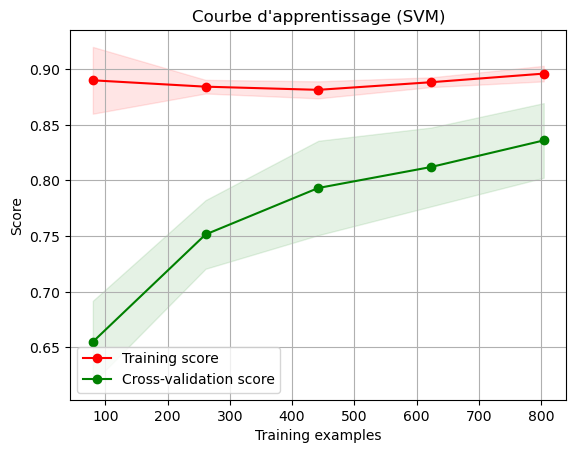

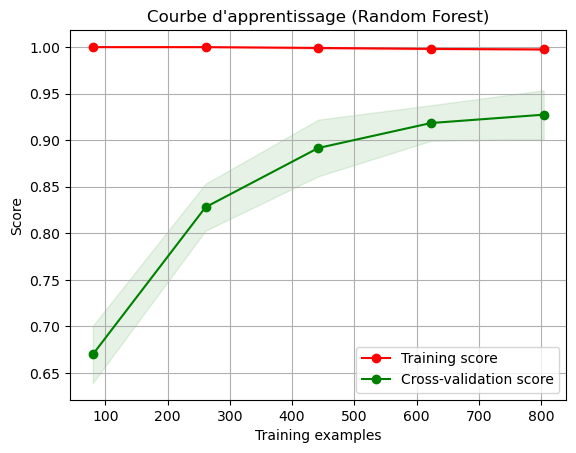

In [99]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color="r", alpha=0.1)
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color="g", alpha=0.1)
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    return plt

# Plot des courbes d'apprentissage
plot_learning_curve(svm_model, "Courbe d'apprentissage (SVM)", X_train, y_train_binary, cv=5)
plot_learning_curve(rf_model, "Courbe d'apprentissage (Random Forest)", X_train, y_train_binary, cv=5)
plt.show()

In [100]:
# # Supposons que new_image_path est le chemin vers votre nouvelle image
# new_features = extract_features([new_image_path])  # Utilisez la fonction d'extraction de caractéristiques définie précédemment
# new_features = new_features.drop(['class', 'x_center', 'y_center', 'width', 'height'], axis=1)  # Assurez-vous d'exclure les cibles

# # Faire des prédictions avec les deux modèles
# svm_pred = svm_model.predict(new_features)
# rf_pred = rf_model.predict(new_features)

# print(f"Prédiction SVM: {svm_pred}")
# print(f"Prédiction Random Forest: {rf_pred}")


In [101]:
print ('X: ({}, {})'.format(*X.shape))
print ('y: ({}, {})'.format(*y.shape))
print ('X_train: ({}, {})'.format(*X_train.shape))
print ('y_train: ({}, {})'.format(*y_train.shape))
print ('X_test: ({}, {})'.format(*X_test.shape))
print ('y_test: ({}, {})'.format(*y_test.shape))

X: (1258, 256)
y: (1258, 5)
X_train: (1006, 256)
y_train: (1006, 5)
X_test: (252, 256)
y_test: (252, 5)


In [102]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [116]:
 # Funtion for cross-validation over a grid of parameters

def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print ("BEST", gs.best_params_, gs.best_score_)
    print("RESULT", gs.cv_results_)
    best = gs.best_estimator_
    return best


In [117]:
# Create a k-Nearest Neighbors Regression estimator
knn_estimator = KNeighborsRegressor()
#knn_parameters = {"n_neighbors": [1,2,5,10,20,50,100]}
knn_parameters = {"n_neighbors": [1,2,5]}
knn_best = cv_optimize(knn_estimator, knn_parameters, X_train, y_train, score_func='neg_mean_squared_error')

BEST {'n_neighbors': 2} -0.01674431667013137
RESULT {'mean_fit_time': array([0.00890307, 0.00661507, 0.00594292]), 'std_fit_time': array([0.00380389, 0.00046758, 0.00064248]), 'mean_score_time': array([0.05713654, 0.04456797, 0.04637351]), 'std_score_time': array([0.02074421, 0.00202695, 0.00534859]), 'param_n_neighbors': masked_array(data=[1, 2, 5],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'n_neighbors': 1}, {'n_neighbors': 2}, {'n_neighbors': 5}], 'split0_test_score': array([-0.02105374, -0.01918349, -0.02654484]), 'split1_test_score': array([-0.01866724, -0.01603825, -0.02403869]), 'split2_test_score': array([-0.01742977, -0.01334311, -0.02544393]), 'split3_test_score': array([-0.01467254, -0.01660254, -0.01841242]), 'split4_test_score': array([-0.01825482, -0.01855419, -0.02433055]), 'mean_test_score': array([-0.01801562, -0.01674432, -0.02375408]), 'std_test_score': array([0.00206065, 0.00206456, 0.00281391]), 'rank_tes

In [118]:
# Fit the best Random Forest and calculate R^2 values for training and test sets
knn_reg=knn_best.fit(X_train, y_train)
knn_training_accuracy = knn_reg.score(X_train, y_train)
knn_test_accuracy = knn_reg.score(X_test, y_test)
print ("############# based on standard predict ################")
print ("R^2 on training data: %0.8f" % (knn_training_accuracy))
print ("R^2 on test data:     %0.8f" % (knn_test_accuracy))

############# based on standard predict ################
R^2 on training data: 0.95162934
R^2 on test data:     0.78673860


In [119]:
# Calculate the Root Mean Squared Error
np.sqrt(mean_squared_error(knn_reg.predict(X_test),y_test))

0.12432293147280819

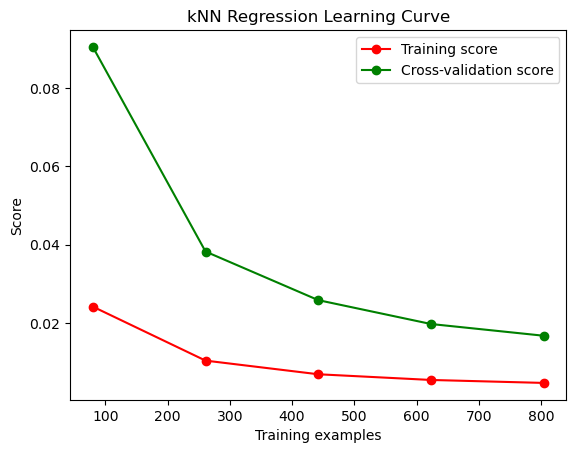

In [120]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='neg_mean_squared_error')
    train_scores_mean = -np.mean(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Après avoir trouvé le meilleur modèle avec cv_optimize
# Tracer la courbe d'apprentissage pour le meilleur modèle
plot_learning_curve(knn_best, "kNN Regression Learning Curve", X_train, y_train, cv=5)
plt.show()